# Image Reconstruction Version 3

This code reconstructs the images from the observations simulated via Karabo using an injected sky models. The injected sky model (HI simulation) used here is generated with Pinocchio and is half-sky, containing: right ascension, declination, observed redshift and flux. OSKAR (on which Karabo is based on) cannot handle continuous sources, so we pass the catalog from HI simulations via PINOCCHIO as point sources.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.time import Time
from datetime import timedelta, datetime
from astropy.coordinates import EarthLocation, AltAz, ICRS
import astropy.units as u
from astropy.constants import c
import copy
from astropy.io import fits
from astropy.wcs import WCS
import os

from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.imaging.imager import Imager
from karabo.util.plotting_util import get_slices
from karabo.simulation.beam import BeamPattern

%matplotlib inline

We define the parameters which we will need for the simulation.

In [23]:
Battye = False

# The file including the sky catalog we want to use for our sky model
if Battye:
    filename = "/home/jennifer/Documents/SKAHIIM_Pipeline/Flux_calculation/Catalog/point_sources_OSKAR1_FluxBattye_diluted5000.h5"
    outfile = "/home/jennifer/Documents/SKAHIIM_Pipeline/result/Reconstructions/DirtyImage_Imager_Battye_BEAM_002"
else:
    filename = "data/point_sources_OSKAR1_diluted5000.h5"
    outfile = "results/DirtyImage_Imager_BEAM_001"

inner_rad = 0
outer_rad = 5.0  # We define the FOV size with an outer and inner radius, the center of the radius is phase-center
area = 5  # angular size of FOV in degrees
channel_num = 10  # Number of frequency channels to be used
timestep_num = 10  # Number of time steps used
PrimBeam_enabled = (
    True  # Set it to true if you want to take into account the primary beam
)

# Values for the plots
if Battye:
    vmax = 0.4
    vmax_i = 0.1
    vmax_rec = 0.25
else:
    vmax = 5
    vmax_i = 1.0
    vmax_rec = 1.5

The observation location should be compatible with the MeerKAT site. Also, the observation time and the coordinate has to be set. We need to pay attention that the sky model passes through the field of view during the observation! Therefore, we choose an observation time and calculate a corresponding possible phase center, which we choose to be the zenith at observation time.

In [24]:
# Observation specifications
# Observation location = MeerKAT location
MeerKAT_lon = "21d26m38.0s"  # Earth location
MeerKAT_lat = "-30d42m39.8s"  # deg. Corresponds to phase center dec.
meerkat_location = EarthLocation(
    lon=MeerKAT_lon, lat=MeerKAT_lat, height=1086.6 * u.m
)  # MeerKAT positon

# Specify an observation time -> take whatever you want
t_obs = "2000-03-20 12:06:39"  # 2022-09-01 09:09:00.
observing_time = Time(t_obs)

# We want to find the phase center which we define to be the zenith at the location of MeerKAT during the observation time
pointing = AltAz(
    alt=90 * u.deg, az=0 * u.deg, location=meerkat_location, obstime=observing_time
)
phase_center = pointing.transform_to(ICRS())
print("The phase center is at:", phase_center)

ra_deg = phase_center.ra.deg
dec_deg = phase_center.dec.deg
print(datetime(2000, 3, 20, 12, 6, 39))

The phase center is at: <ICRS Coordinate: (ra, dec) in deg
    (21.44213503, -30.70729488)>
2000-03-20 12:06:39


We create the sky model. To do so we read in the catalog from the HI simulations. Then, we only take sources in account which are within a certain radius (in degrees), which corresponds to our chosen FOV.

In [25]:
catalog = h5py.File(filename, "r")
print("The catalog keys are:", list(catalog.keys()))
print("The unit of the flux given here is:", catalog["Flux"].attrs["Units"])
print("Number of elements in the complete catalog:", len(catalog["Declination"][()]))

ra = np.array(catalog["Right Ascension"])
dec = (
    np.array(catalog["Declination"]) * -1
)  # We multiply by -1 to change the catalog to the Southern sky
if Battye:
    flux = np.array(
        catalog["Flux"]
    )  # Using the formula from Battye, the flux is already given in Jy
else:
    flux = np.array(catalog["Flux"]) * 10**26  # We multiply with the factor to get Jy
z_obs = np.array(catalog["Observed Redshift"])
catalog.close()

# We construct the sky model from the catalog information with Karabo
sky_data = np.zeros((len(ra), 12))
sky_data[:, 0] = ra
sky_data[:, 1] = dec
sky_data[:, 2] = flux
sky = SkyModel()
sky.add_point_sources(sky_data)
# print(sky_data)

# We only take into account a certain FOV, we filter the sky for this FOV
sky_filter, filter_in = sky.filter_by_radius(
    ra0_deg=ra_deg,
    dec0_deg=dec_deg,
    inner_radius_deg=inner_rad,
    outer_radius_deg=outer_rad,
    indices=True,
)
z_obs_filter = z_obs[filter_in]
print(
    "Number of elements in diluted catalog in the interesting FOV:",
    len(sky_filter[:, 0]),
)

The catalog keys are: ['Declination', 'Flux', 'Observed Redshift', 'Right Ascension']
The unit of the flux given here is: J/m²/s = 10^(26)*Jy*Hz
Number of elements in the complete catalog: 223930
Number of elements in diluted catalog in the interesting FOV: 1316


Scatter plot of the diluted sky model in the FOV.

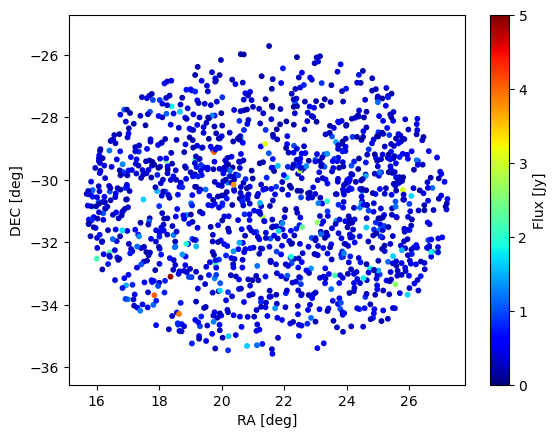

In [26]:
# We do a scatter plot with the function from karabo
sky_filter.explore_sky(
    phase_center=(ra_deg, dec_deg),
    vmin=0,
    vmax=vmax,
    s=10,
    cmap="jet",
    cbar_label="Flux [Jy]",
    cfun=None,
    wcs_enabled=False,
    xlabel="RA [deg]",
    ylabel="DEC [deg]",
)

Depending on the number of frequency channels we would like to observe in we should have the edges of the channels. Here the assumption is that the channels are uniformly binned, so we use linspace function from the numpy library. But any type of binning is possible.

We recall that $1+z = \frac{\lambda_{obs}}{\lambda_{emit}}$, where the emitting wavelength of HI is 21 cm = 0.21m and $\lambda = \frac{c}{f}$. Therefore $f_{obs} = \frac{c}{0.21(1+z)}$.

In [27]:
redshift_channel = np.linspace(
    np.amin(z_obs_filter), np.amax(z_obs_filter), channel_num + 1
)

print("Smallest redshift:", np.amin(z_obs_filter))
print("Largest redshift:", np.amax(z_obs_filter))

freq_start = c.value / (0.21 * (1 + redshift_channel[0]))
freq_end = c.value / (0.21 * (1 + redshift_channel[-1]))
freq_mid = freq_start + (freq_end - freq_start) / 2
freq_bin = c.value / (0.21 * (redshift_channel[1] - redshift_channel[0]))
print("The frequency channel starts at:", freq_start, "Hz")
print("The bin size of each freq channel is:", freq_bin, "Hz")
print("The freq channel: ", c.value / (0.21 * (1 + redshift_channel)))

Smallest redshift: 0.769394
Largest redshift: 1.030887
The frequency channel starts at: 806820376.5432308 Hz
The bin size of each freq channel is: 54593550624.04466 Hz
The freq channel:  [8.06820377e+08 7.95070291e+08 7.83657535e+08 7.72567790e+08
 7.61787533e+08 7.51303987e+08 7.41105068e+08 7.31179340e+08
 7.21515972e+08 7.12104697e+08 7.02935778e+08]


We are going to loop through the channel numbers and different beam patterns. We need to do this, because our flux is generated by line emission, but karabo is initially made for a continuum spectrum.

The details for working with Karabo can be found here https://i4ds.github.io/Karabo-Pipeline/.

We first need to set the telescope, then the simulation and observation settings. In the next step we do the simulation by using the sky model defined above and calling the interferometer (from karabo) to calculate the visibilities. Afterwards, the dirty images can be reconstructed via the imager (from karabo).

Since we are simulating a finite lightcone as we move towards edges of the lightcone we see a drifting behavior of sources which is an artefact of hitting the edges of the cone. But in our case we do not see it, since we only plot the area in the center.


Computing Primary Beam from KatBeamfor frequency806.8203765432307
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:43:49 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174349.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/bab2e64d-97ac-490f-9e7a-6d986b6afde4'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 806820376.5432308
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

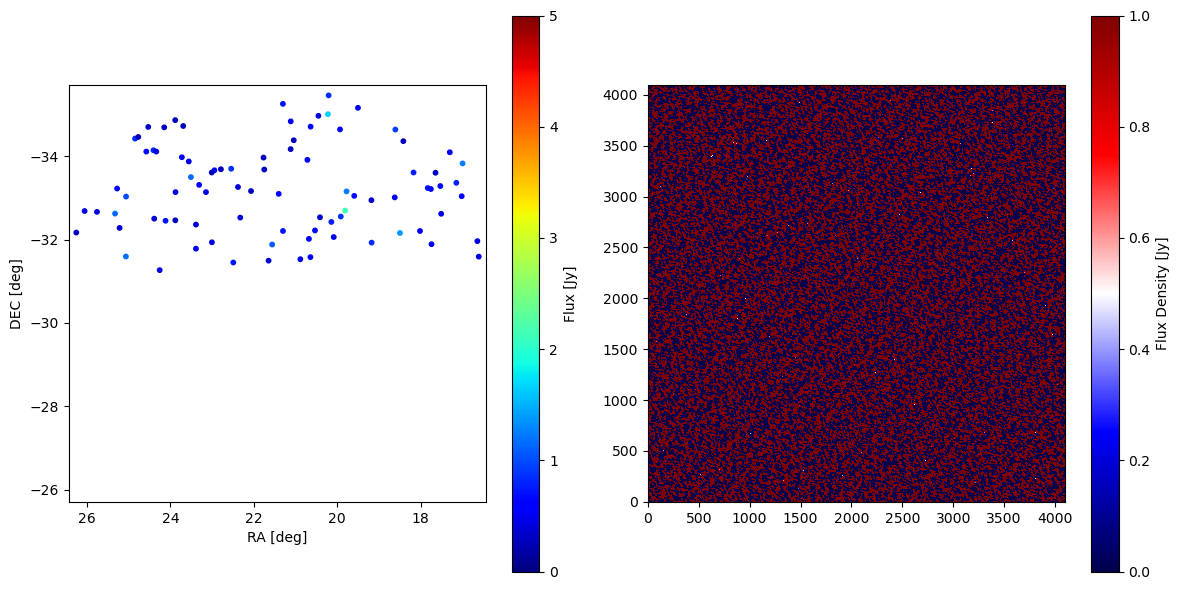

Computing Primary Beam from KatBeamfor frequency795.0702906097187
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:44:11 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174411.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/cb46c6e1-6c6f-49a0-bb3f-d65d7451aa81'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 795070290.6097187
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

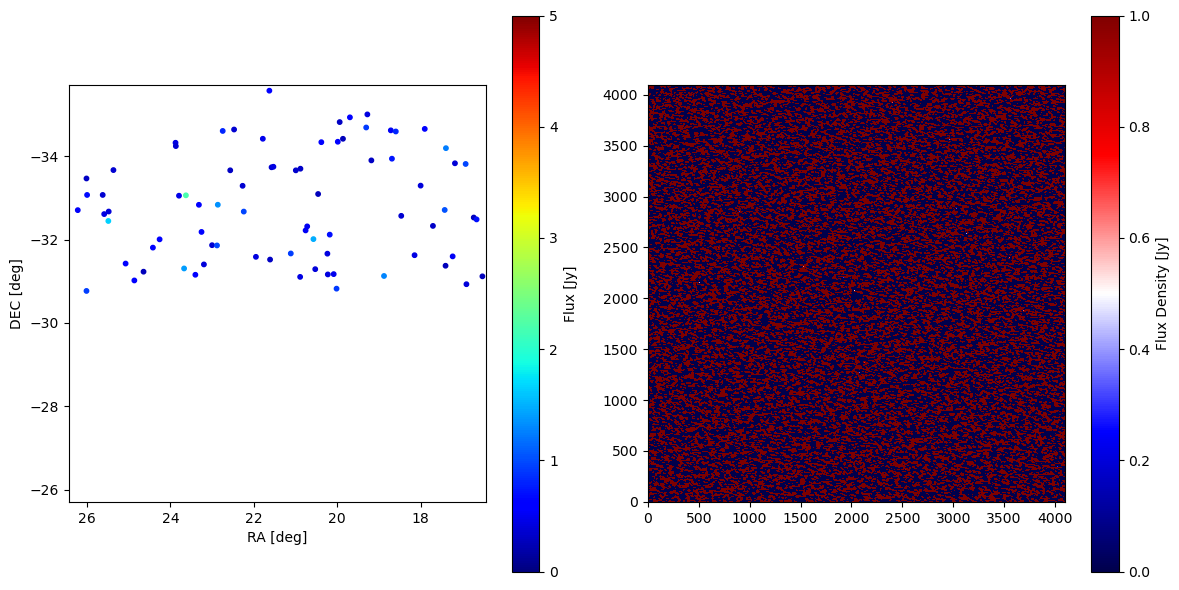

Computing Primary Beam from KatBeamfor frequency783.6575354883329
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:44:34 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174434.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/72167cdd-f416-425c-8d15-e027851f9fea'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 783657535.4883329
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

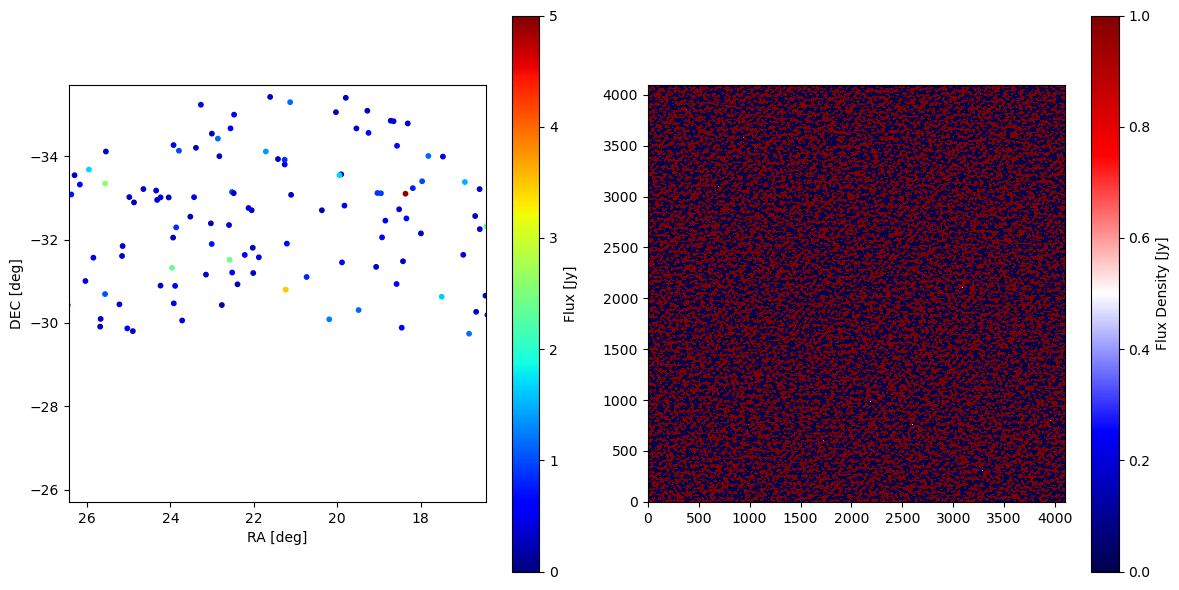

Computing Primary Beam from KatBeamfor frequency772.5677902061498
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:44:59 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174459.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/2761d5fb-8388-41f8-9059-623b279d7237'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 772567790.2061499
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

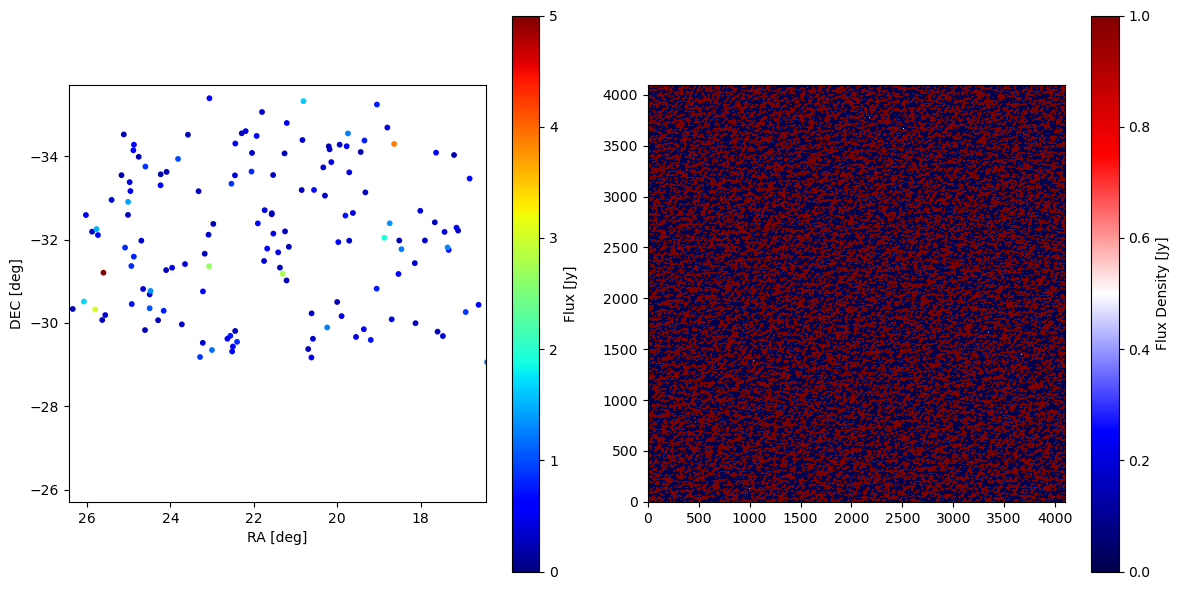

Computing Primary Beam from KatBeamfor frequency761.787533118263
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:45:23 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174523.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/6b71037e-aac6-45ba-b9e8-04c5518cd799'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 761787533.118263
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 0.

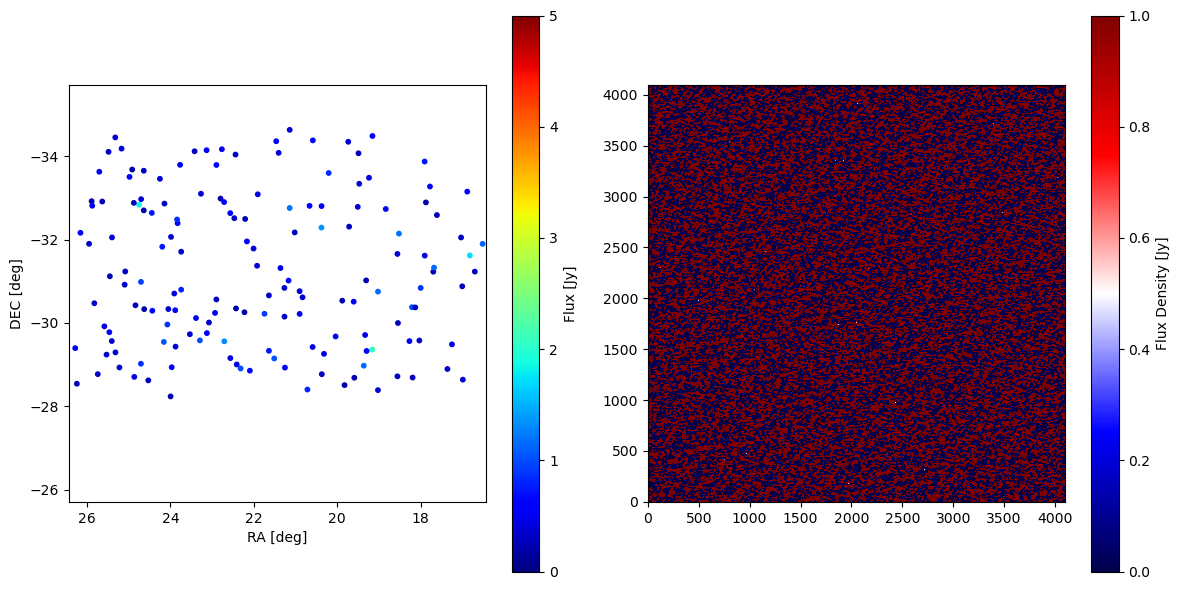

Computing Primary Beam from KatBeamfor frequency751.3039869069331
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:45:47 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174547.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/7c872164-0506-4d5b-bc40-c0dabf9440c5'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 751303986.906933
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 0

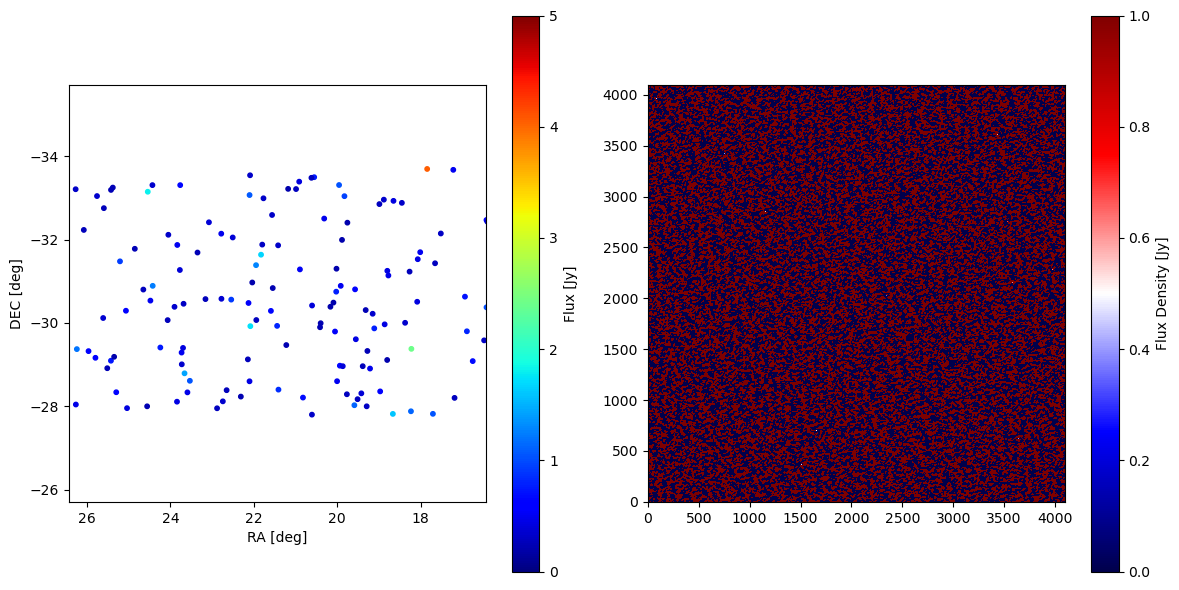

Computing Primary Beam from KatBeamfor frequency741.1050680605447
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:46:10 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174610.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/a7ad552f-5499-45c9-a440-4e11c604d629'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 741105068.0605447
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

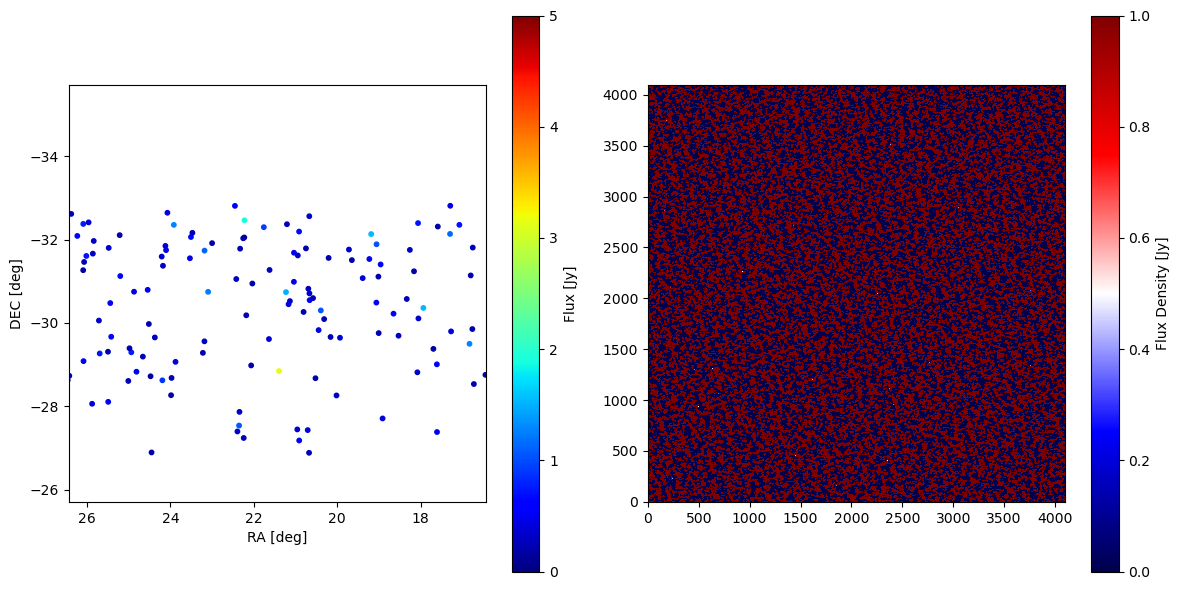

Computing Primary Beam from KatBeamfor frequency731.1793404123762
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:46:33 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174633.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/7db1d1df-41b9-4dad-92e2-c3957a961b5d'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 731179340.4123762
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

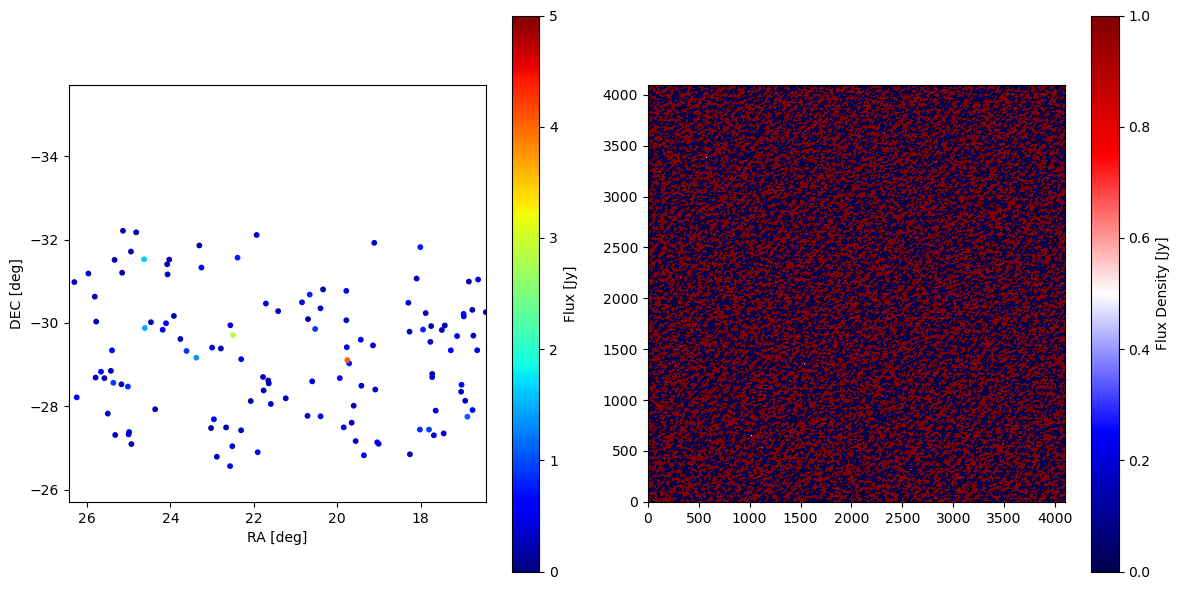

Computing Primary Beam from KatBeamfor frequency721.5159723635969
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:46:55 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174655.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/1347412d-0eb0-42b3-979e-13976e987afc'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 721515972.3635969
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

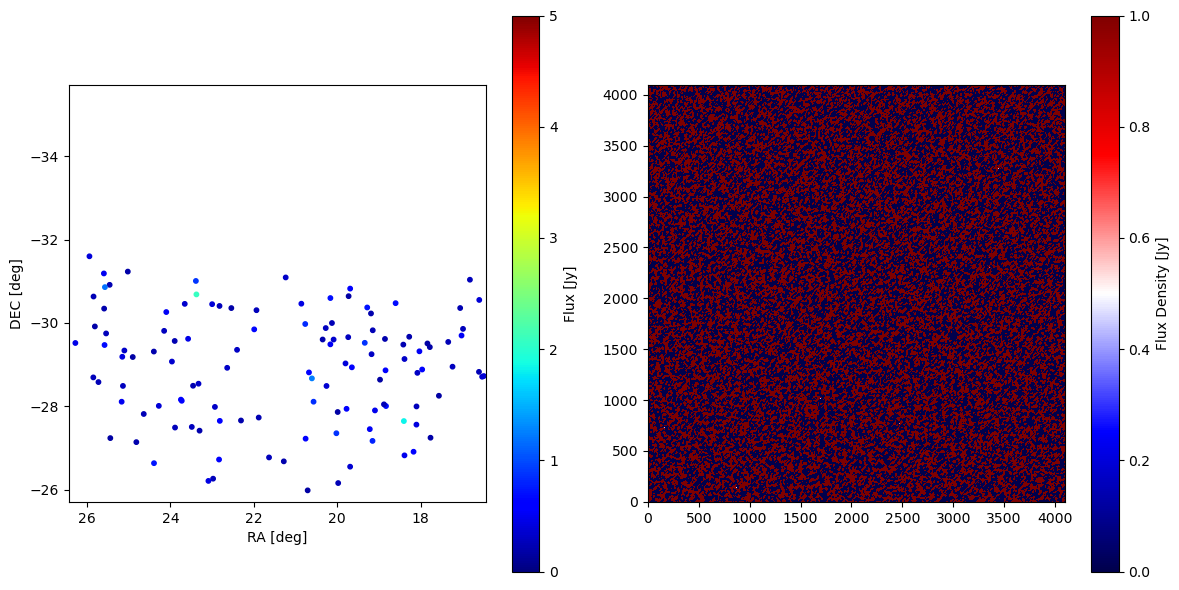

Computing Primary Beam from KatBeamfor frequency712.1046974541025
(40, 40) (40, 40)
(1600,) (1600,)
 |                                                                   
=|== OSKAR-2.8.3 starting at 2023-02-21, 17:47:20 (CET).
 |                                                                   
 | + Current dir is /home/jennifer/Karabo-Pipeline/karabo/examples
 | + Logging to file oskar_2023-02-21_174720.log
 |                                                                   
=|== Loaded settings file '/home/jennifer/Karabo-Pipeline/karabo/examples/.tmp/260265dc-5ca3-44fb-930c-a2bb457ce035'
 |                                                                   
 | + Element pattern fitting settings
 |   - Input CST file: /home/jennifer/Documents/SKAHIIM_Pipeline/data/cst_like_beam_port_1.txt
 |   - Frequency [Hz]                    : 712104697.4541025
 |   - Polarisation type                 : X
 |   - Ignore data at poles              : true
 |   - Average fractional error          : 

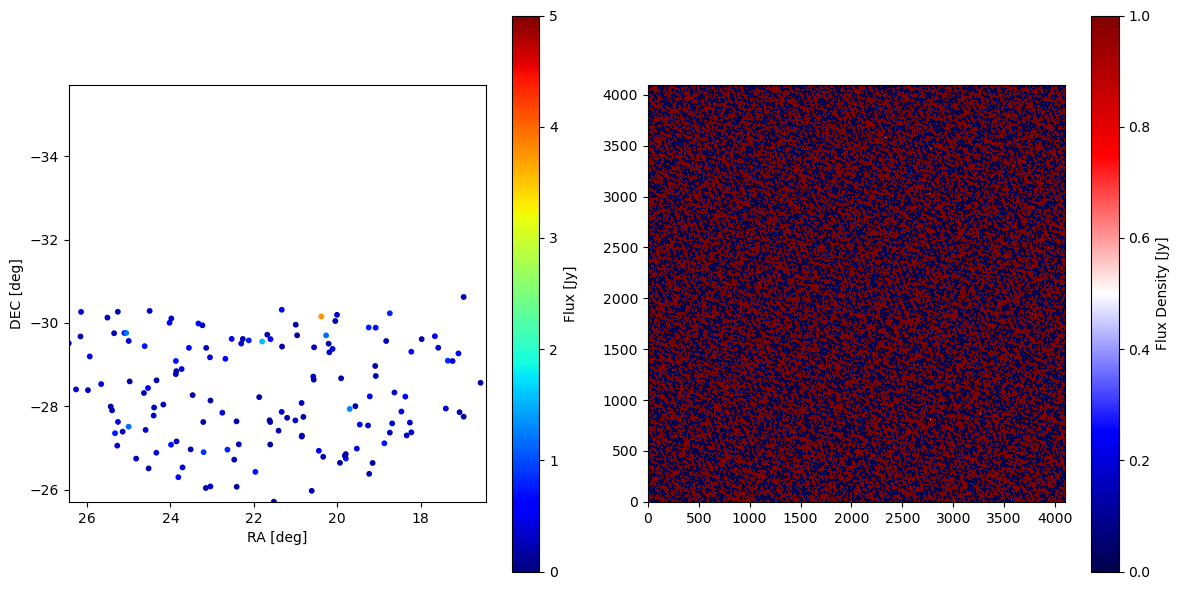

In [28]:
# We loop over the different frequency channels to account for the fact that we have line emission and not a continuous spectrum

dirty_slices = []
visibility_slices = []

for i in range(channel_num):
    chan_name = "results/halo_sources_channel" + str(i)

    # We first define the telescope that we are going to use, which is MeerKAT
    telescope = Telescope.get_MEERKAT_Telescope()

    # If PrimBeam_enabled is True, we take into account the primary beam
    if PrimBeam_enabled:
        # We need to take into account the primary beam
        xcstfile_path = "data/cst_like_beam_port_1.txt"
        ycstfile_path = "data/cst_like_beam_port_2.txt"

        # Remove beam if already present
        test = os.listdir(telescope.path)
        for item in test:
            if item.endswith(".bin"):
                os.remove(os.path.join(telescope.path, item))

        # ------------ X-coordinate
        pb = BeamPattern(xcstfile_path)  # Instance of the Beam class
        beam = pb.sim_beam(
            beam_method="KatBeam",
            f=c.value / (0.21 * (1 + redshift_channel[i])) / 10**6,
            fov=20,
        )  # Computing beam
        pb.save_meerkat_cst_file(beam[3])  # Saving the beam cst file
        pb.fit_elements(
            telescope,
            freq_hz=c.value / (0.21 * (1 + redshift_channel[i])),
            avg_frac_error=0.01,
            pol="X",
        )  # Fitting the beam using cst file

        # ------------ Y-coordinate
        pb = BeamPattern(ycstfile_path)
        pb.save_meerkat_cst_file(beam[4])
        pb.fit_elements(
            telescope,
            freq_hz=c.value / (0.21 * (1 + redshift_channel[i])),
            avg_frac_error=0.01,
            pol="Y",
        )

    # Simulation of the interferometer
    simulation = InterferometerSimulation(
        vis_path=chan_name + ".vis",
        channel_bandwidth_hz=1.0e7,
        time_average_sec=8,
        ignore_w_components=True,
        noise_enable=False,
        noise_seed="time",
        noise_freq="Range",
        noise_rms="Range",
        noise_start_freq=1.0e9,
        noise_inc_freq=1.0e8,
        noise_number_freq=24,
        noise_rms_start=5000,
        noise_rms_end=10000,
        enable_numerical_beam=PrimBeam_enabled,
        enable_array_beam=PrimBeam_enabled,
    )

    # Observation settings
    observation = Observation(
        phase_centre_ra_deg=ra_deg,
        phase_centre_dec_deg=dec_deg,
        start_date_and_time=datetime(2000, 3, 20, 12, 6, 39),
        length=timedelta(hours=0, minutes=5, seconds=0, milliseconds=0),
        number_of_time_steps=10,
        start_frequency_hz=c.value / (0.21 * (1 + redshift_channel[i])),
        frequency_increment_hz=freq_bin,
        number_of_channels=channel_num,
    )

    # In this step we mask the dataframe to the respective frequency bin. Since we're using 21cm sources there's a one to one correspondence between redshift and distance.
    sky_bin = copy.deepcopy(sky_filter)
    sky_bin_idx = np.where(
        (z_obs_filter > redshift_channel[i]) & (z_obs_filter < redshift_channel[i + 1])
    )
    sky_bin.sources = sky_bin.sources[sky_bin_idx]

    visibility = simulation.run_simulation(telescope, sky_bin, observation)

    imager = Imager(
        visibility, imaging_npixel=2048 * 2, imaging_cellsize=4.3e-5, imaging_dopsf=True
    )
    dirty = imager.get_dirty_image()
    dirty.write_to_file(chan_name + ".fits", overwrite=True)
    # dirty.plot(title='Flux Density [Jy]')

    # Plot the scatter plot and the sky reconstruction next to each other
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    scatter = ax1.scatter(
        sky_bin[:, 0],
        sky_bin[:, 1],
        c=sky_bin[:, 2],
        vmin=0,
        vmax=vmax,
        s=10,
        cmap="jet",
    )
    ax1.set_aspect("equal")
    plt.colorbar(scatter, ax=ax1, label="Flux [Jy]")
    ax1.set_xlim((ra_deg - outer_rad, ra_deg + outer_rad))
    ax1.set_ylim((dec_deg - outer_rad, dec_deg + outer_rad))
    ax1.set_xlabel("RA [deg]")
    ax1.set_ylabel("DEC [deg]")
    ax1.invert_xaxis()
    ax1.invert_yaxis()

    recon_img = ax2.imshow(
        dirty.data[0][0], cmap="seismic", origin="lower", vmin=0, vmax=vmax_i
    )
    plt.colorbar(recon_img, ax=ax2, label="Flux Density [Jy]")

    plt.tight_layout()
    plt.show()

    # At the end we want a reconstruction of the complete sky_filter. Therefore, we save all dirty images in a list
    dirty_slices.append(dirty.data[0][0])
    # We also want to save the visibilities later
    visibility_slices.append(visibility)

dirty_image = sum(dirty_slices)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 21.442135027607  -30.707294877527  1.0  712104697.4541  
CRPIX : 2049.0  2049.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0024637185190625  0.0024637185190625  1.0  54593550624.045  
NAXIS : 4096  4096  1  10


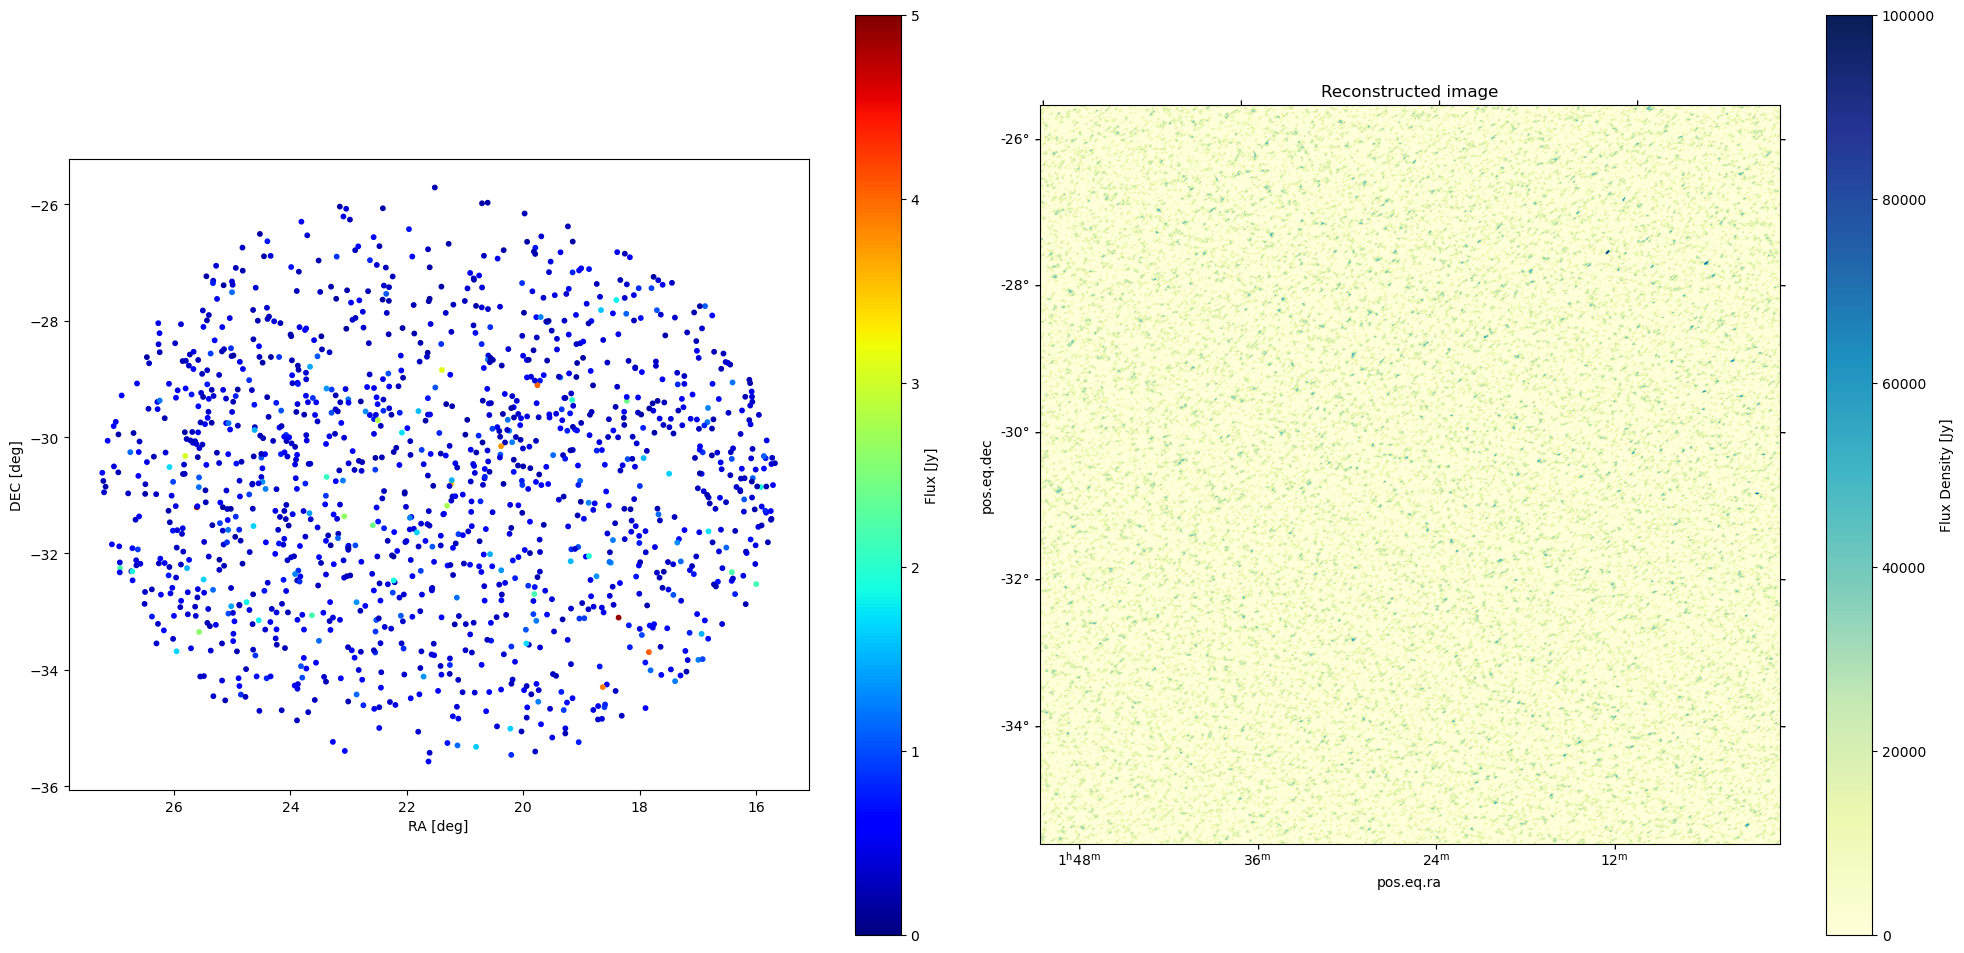

In [29]:
# Plot the scatter plot and the sky reconstruction next to each other of the whole sky (all slices together)

## First we define the wcs frame
_, header = fits.getdata(chan_name + ".fits", ext=0, header=True)

wcs = WCS(header)
print(wcs)

slices = get_slices(wcs)

plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
scatter = ax1.scatter(
    sky_filter[:, 0],
    sky_filter[:, 1],
    c=sky_filter[:, 2],
    vmin=0,
    vmax=vmax,
    s=10,
    cmap="jet",
)
ax1.set_aspect("equal")
plt.colorbar(scatter, ax=ax1, label="Flux [Jy]")
# ax1.set_xlim((ra_deg-area/2, ra_deg+area/2))
# ax1.set_ylim((dec_deg-area/2, dec_deg+area/2))
ax1.set_xlabel("RA [deg]")
ax1.set_ylabel("DEC [deg]")
ax1.invert_xaxis()

ax2 = plt.subplot(122, projection=wcs, slices=slices)
recon_img = ax2.imshow(dirty_image, cmap="YlGnBu", origin="lower", vmin=0, vmax=1e05)
plt.colorbar(recon_img, ax=ax2, label="Flux Density [Jy]")

plt.title("Reconstructed image")
plt.tight_layout()
plt.savefig(outfile + ".pdf")
plt.show()

In [30]:
dirty_img = fits.PrimaryHDU(dirty_image)
dirty_img.writeto(outfile + ".fits", overwrite=True)

As a next step we save the dirty image slices according to corresponding redshifts in a h5 file. We do the same for the visibilities.

In [31]:
print(redshift_channel)
z_bin = redshift_channel[1] - redshift_channel[0]
print(z_bin)
z_channel_mid = redshift_channel + z_bin / 2
print(z_channel_mid)

[0.769394  0.7955433 0.8216926 0.8478419 0.8739912 0.9001405 0.9262898
 0.9524391 0.9785884 1.0047377 1.030887 ]
0.026149300000000042
[0.78246865 0.80861795 0.83476725 0.86091655 0.88706585 0.91321515
 0.93936445 0.96551375 0.99166305 1.01781235 1.04396165]


In [32]:
# Create HDF5 file:
f = h5py.File(outfile + "_" + str(channel_num) + "slices.h5", "w")

dataset_dirty = f.create_dataset("Dirty Images", data=dirty_slices)
dataset_dirty.attrs["Units"] = "Jy"

f.create_dataset("Observed Redshift Channel Center", data=z_channel_mid)

f.create_dataset("Observed Redshift Bin Size", data=z_bin)

<HDF5 dataset "Observed Redshift Bin Size": shape (), type "<f8">

In [ ]:
# The visbilities are already saved in vis files as chan_name+.vis and we can call them like this:
import oskar

(visHeader, visHandle) = oskar.VisHeader.read(chan_name + ".vis")
visBlock = oskar.VisBlock.create_from_header(visHeader)
print(visHeader.num_blocks)
for i in range(visHeader.num_blocks):
    visBlock.read(visHeader, visHandle, i)
    print(visBlock.start_time_index)
# vis = visBlock.cross_correlations()
uu = visBlock.baseline_uu_metres()
vv = visBlock.baseline_vv_metres()

plt.figure()
plt.scatter(uu, vv, s=2, marker="*")
plt.show()